In [1]:
import tensorflow as tf
import os
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from nilearn import image
from nilearn import plotting
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = '/local-scratch/localhome/mkhademi/BOLD5000_2.0/'
batch_size = 20
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_coco.tfrecords']).batch(batch_size)
train_ds = dataset.take(1800//batch_size)
test_ds = dataset.skip(1800//batch_size)
test_ds = test_ds.take(200//batch_size)
train_ds = train_ds.shuffle(1800)

In [3]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'y': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12), dtype=tf.int64),
            'y_face': tf.io.FixedLenFeature(shape=(2), dtype=tf.int64),
        })
    return example['x'], example['y_face']
    
decoded = train_ds.map(tf_parse)
decoded_test = test_ds.map(tf_parse)

In [4]:
raw_example = next(iter(test_ds))
print(tf_parse(raw_example)[0].numpy().shape)
print(tf_parse(raw_example)[1].numpy().shape)
print(tf_parse(raw_example)[1].numpy().sum(axis=1))

(20, 71, 89, 72, 1)
(20, 2)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [5]:
for x_batch, y_batch in decoded_test.take(1):
    print(x_batch.shape, y_batch.shape)

(20, 71, 89, 72, 1) (20, 2)


In [6]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(71, 89, 72, 1)),
    tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
    # tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv2'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
    # tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv3'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    # tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(2),
    # tf.keras.layers.Softmax()
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten (Flatten)            (None, 26928)             0         
_________________________________________________________________
dropout (Dropout)            (None, 26928)             0

In [7]:
model.compile(
    # loss='mse',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    # loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # optimizer=keras.optimizers.RMSprop(),
    optimizer='adam',
    # metrics=[tf.keras.metrics.MeanSquaredError()],
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    # metrics=[tf.keras.metrics.CategoricalCrossentropy(from_logits=True)]
)
model.fit(decoded, epochs=60)

Epoch 1/60
90/90 [==============================] - 17s 132ms/step - loss: 86.5314 - categorical_accuracy: 0.6106
Epoch 2/60
90/90 [==============================] - 14s 133ms/step - loss: 38.6935 - categorical_accuracy: 0.6422
Epoch 3/60
90/90 [==============================] - 14s 133ms/step - loss: 46.1836 - categorical_accuracy: 0.6539
Epoch 4/60
90/90 [==============================] - 15s 134ms/step - loss: 25.2683 - categorical_accuracy: 0.6617
Epoch 5/60
90/90 [==============================] - 14s 135ms/step - loss: 19.5934 - categorical_accuracy: 0.6828
Epoch 6/60
90/90 [==============================] - 15s 135ms/step - loss: 10.6856 - categorical_accuracy: 0.7028
Epoch 7/60
90/90 [==============================] - 14s 135ms/step - loss: 5.7977 - categorical_accuracy: 0.7222
Epoch 8/60
90/90 [==============================] - 15s 142ms/step - loss: 9.7151 - categorical_accuracy: 0.7161
Epoch 9/60
90/90 [==============================] - 15s 138ms/step - loss: 6.5766 - catego

/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


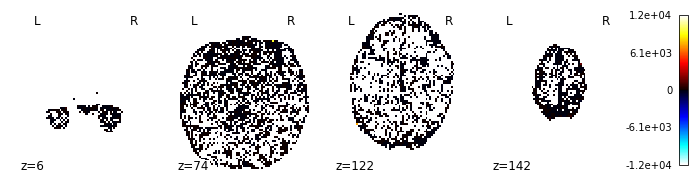

In [8]:
img4d = image.load_img(data_dir + 'CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz');
selected_volumes = image.index_img(img4d, slice(200, 201))
imgs = [img for img in image.iter_img(selected_volumes)]
img = imgs[0]
mask = np.zeros(img.shape) * image.get_data(img)
plot_stat_map(img, threshold='auto', display_mode="z", cut_coords=4, bg_img=None)

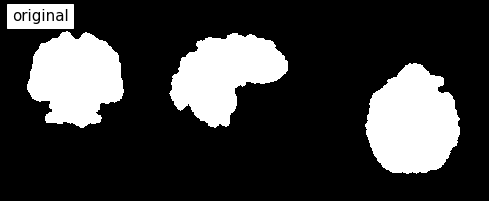

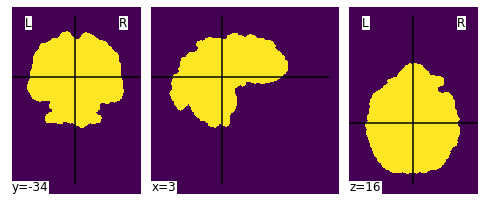

In [9]:
anat = '/local-scratch/localhome/mkhademi/ds001499/derivatives/fmriprep/sub-CSI1/anat/sub-CSI1_T1w_brainmask.nii.gz'   
plot_anat(anat, title='original', display_mode='ortho', dim=-1, draw_cross=False, annotate=False)
plot_img(anat)

Datasets are stored in: ['/localhome/mkhademi/nilearn_data']


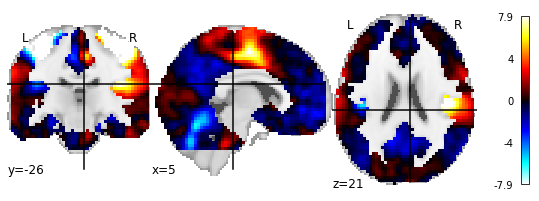

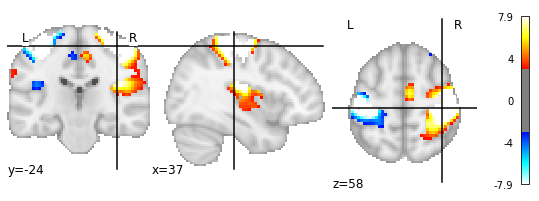

In [10]:
from nilearn import datasets
print('Datasets are stored in: %r' % datasets.get_data_dirs())
motor_images = datasets.fetch_neurovault_motor_task()
motor_images.images
tmap_filename = motor_images.images[0]
plot_stat_map(tmap_filename)
plot_stat_map(tmap_filename, threshold=3)

In [11]:
img = np.array(img.dataobj)
print(np.max(img))
print(np.min(img))

9611.976
-12267.824


In [12]:
vis_output = model.get_layer('conv2').output
print(vis_output.shape)
vis_model = tf.keras.models.Model(inputs=model.input, outputs=vis_output)
vis_face = np.zeros(vis_output.shape[1:4])
vis_noface = np.zeros(vis_output.shape[1:4])
count_face = 0
count_noface = 0
for x_batch, y_batch in decoded:
    output = vis_model.predict(x_batch)
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            vis_face += output[i][:,:,:,0] 
            count_face += 1
        else:
            vis_noface += output[i][:,:,:,0]
            count_noface += 1
                      
print(count_face)
print(count_noface)
vis_face = vis_face/count_face 
vis_noface = vis_noface/count_noface 
# print(vis_face) 
print(np.max(vis_face))
print(np.min(vis_face))

(None, 71, 89, 72, 2)
470
1330
236.0170819048552
0.0


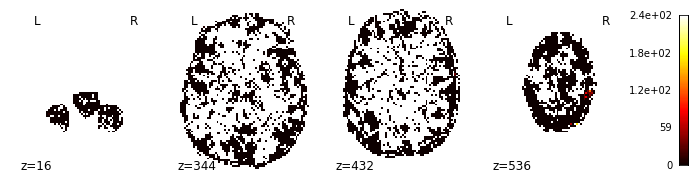

In [13]:
vis_face += mask
vis_noface += mask
nifti_file = nib.nifti1.Nifti1Image(dataobj=vis_face, affine=8*np.eye(4), header=None, extra=None, file_map=None)
plot_stat_map(nifti_file, threshold='auto', display_mode="z", cut_coords=4, bg_img=None)

In [14]:
loss, accuracy = model.evaluate(decoded_test)

10/10 [==============================] - 2s 49ms/step - loss: 0.5021 - categorical_accuracy: 0.8050


In [15]:
model.add(tf.keras.layers.Softmax())
for x_batch, y_batch in decoded_test.take(1):
    print(model(x_batch))
pos = 0
neg = 0
for x_batch, y_batch in decoded_test:
    for i in range(y_batch.shape[0]):
        if y_batch[i][0] == 1:
            pos += 1
        else:
            neg += 1
print(pos)
print(neg)

tf.Tensor(
[[0.07201896 0.927981  ]
 [0.25673762 0.7432624 ]
 [0.46825814 0.53174186]
 [0.13749994 0.8625    ]
 [0.00492187 0.9950781 ]
 [0.04051205 0.9594879 ]
 [0.18128838 0.81871164]
 [0.08591151 0.9140884 ]
 [0.6977952  0.30220476]
 [0.23283644 0.7671635 ]
 [0.15664876 0.84335124]
 [0.95482594 0.04517409]
 [0.16977261 0.83022743]
 [0.7225768  0.2774232 ]
 [0.00177293 0.99822706]
 [0.46490145 0.5350986 ]
 [0.5715559  0.42844412]
 [0.01713209 0.98286796]
 [0.96277815 0.03722188]
 [0.2526947  0.7473053 ]], shape=(20, 2), dtype=float32)
50
150


In [16]:
batch_size = 20
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/bold5000_common.tfrecords']).batch(batch_size)
train_ds = dataset.take((2135+400)//batch_size)
test_ds = dataset.skip((2135+400)//batch_size)
test_ds = test_ds.take(329//batch_size)
train_ds = train_ds.shuffle(2135+400)

In [17]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'y': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12), dtype=tf.int64),
            'y_face': tf.io.FixedLenFeature(shape=(2), dtype=tf.int64),
        })
    return example['x'], example['y_super']
    
decoded = train_ds.map(tf_parse)
decoded_test = test_ds.map(tf_parse)

In [18]:
raw_example = next(iter(test_ds))
print(tf_parse(raw_example)[0].numpy().shape)
print(tf_parse(raw_example)[1].numpy().shape)
print(tf_parse(raw_example)[1].numpy().sum(axis=1))

(20, 71, 89, 72, 1)
(20, 12)
[1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1]


In [19]:
for x_batch, y_batch in decoded_test.take(1):
    print(x_batch.shape)

(20, 71, 89, 72, 1)


In [20]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(71, 89, 72, 1)),
    tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
    # tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(2, 3, padding='same', name='conv2'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
    # tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv3'),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(12, activation='sigmoid'),
    # tf.keras.layers.Softmax()
    ])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 71, 89, 72, 1)     28        
_________________________________________________________________
conv2 (Conv3D)               (None, 71, 89, 72, 2)     56        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 35, 44, 36, 2)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 35, 44, 36, 4)     220       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 17, 22, 18, 4)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26928)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26928)            

In [21]:
model.compile(
    # loss='mse',
    # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    # optimizer=keras.optimizers.RMSprop(),
    optimizer='adam',
    # metrics=[tf.keras.metrics.MeanSquaredError()],
    # metrics=[tf.keras.metrics.CategoricalAccuracy()],
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)
model.fit(decoded, epochs=60)

Epoch 1/60
126/126 [==============================] - 21s 133ms/step - loss: 29.6867 - binary_accuracy: 0.7701
Epoch 2/60
126/126 [==============================] - 20s 134ms/step - loss: 12.3584 - binary_accuracy: 0.7923
Epoch 3/60
126/126 [==============================] - 21s 143ms/step - loss: 5.7871 - binary_accuracy: 0.8021
Epoch 4/60
126/126 [==============================] - 21s 142ms/step - loss: 4.2063 - binary_accuracy: 0.8118
Epoch 5/60
126/126 [==============================] - 21s 140ms/step - loss: 2.5923 - binary_accuracy: 0.8223
Epoch 6/60
126/126 [==============================] - 21s 139ms/step - loss: 2.4690 - binary_accuracy: 0.8306
Epoch 7/60
126/126 [==============================] - 21s 139ms/step - loss: 1.8637 - binary_accuracy: 0.8401
Epoch 8/60
126/126 [==============================] - 21s 139ms/step - loss: 1.7309 - binary_accuracy: 0.8473
Epoch 9/60
126/126 [==============================] - 21s 138ms/step - loss: 1.4913 - binary_accuracy: 0.8544
Epoch 10

In [22]:
loss, accuracy = model.evaluate(decoded_test)

16/16 [==============================] - 6s 47ms/step - loss: 0.5759 - binary_accuracy: 0.8484


In [23]:
for x_batch, y_batch in decoded_test.take(1):
    #print(tf.keras.activations.sigmoid(model(x_batch)))
    print(model(x_batch))

tf.Tensor(
[[4.97726381e-01 1.21875445e-03 2.07167235e-03 9.59937513e-01
  1.32490113e-01 2.38511905e-01 1.15855466e-04 1.65915335e-04
  5.05410554e-03 6.43098538e-05 6.38399615e-06 2.69228767e-04]
 [5.06764627e-04 5.17342146e-03 2.89318468e-05 9.87263858e-01
  1.53483544e-03 2.22253698e-06 1.95824236e-01 5.42054586e-05
  1.72778130e-01 5.78274857e-03 8.84934515e-03 9.33808333e-04]
 [6.62317514e-01 3.71079832e-01 2.21020906e-04 9.43283200e-01
  2.19055172e-03 5.79968607e-03 1.16320989e-05 1.56160491e-03
  1.17782898e-01 1.49487406e-01 2.54071929e-05 2.04449123e-07]
 [6.52572289e-02 2.35771135e-04 3.29325616e-04 9.83298600e-01
  1.57876275e-04 3.40755749e-03 2.72699283e-04 3.92938359e-03
  5.44539154e-01 5.34684455e-04 2.49914272e-04 3.41328385e-04]
 [4.84452830e-05 5.46201691e-03 3.18584216e-06 3.59483883e-02
  4.49057552e-06 1.40841154e-03 4.45729792e-02 1.74889863e-01
  7.78954327e-01 8.96361545e-02 4.97294066e-04 7.01412916e-01]
 [6.31697953e-01 9.75189209e-01 1.67351573e-05 3.31540